In [26]:
%matplotlib inline

import json
import ast

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from typing import List

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

from sklearn.model_selection import train_test_split

from jass.logs.game_log_entry import GameLogEntry
from jass.game.game_state import GameState
from jass.game.game_state_util import state_from_complete_game, observation_from_state
from jass.game.game_util import convert_int_encoded_cards_to_str_encoded, convert_one_hot_encoded_cards_to_str_encoded_list

from jass.game.rule_schieber import RuleSchieber

game_rule = RuleSchieber()
path_to_data = Path('../data')

## Dataset Structure for Model Training

### Simple
Features: (2x36 = 72)
- cards played in current round (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

### More Useful Information
Features: (4x36 = 144)
- already played cards (9x9 = 36)
- cards played in current round (9x9 = 36)
- cards in hand (9x9 = 36)
- valid cards (9x9 = 36)

Target: (9x9 = 36 -> only select one! / or probability)
- choose one of the valid cards in own hand
- one-hot-encoding of all cards
- select only cards that are available
- select only cards that are valid

## Simple Model

First we have to import the generated Dataset and do some preprocessing for the model to learn the data

In [3]:
cards = [
    # Diamonds
    'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
    # Hearts
    'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
    # Spades
    'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
    # Clubs
    'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

played_cards_columns = ['played_cards_' + card for card in cards]
valid_cards_columns = ['valid_cards_' + card for card in cards]
selected_card_columns = ['selected_card_' + card for card in cards]

### Preprocessing

In [ ]:
data = pd.read_csv(path_to_data / 'card_prediction' / 'card_prediction_0002.csv')

data.head()

,trump,played_cards_DA,played_cards_DK,played_cards_DQ,played_cards_DJ,played_cards_D10,played_cards_D9,played_cards_D8,played_cards_D7,played_cards_D6,...,selected_card_S6,selected_card_CA,selected_card_CK,selected_card_CQ,selected_card_CJ,selected_card_C10,selected_card_C9,selected_card_C8,selected_card_C7,selected_card_C6
0,HEARTS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,HEARTS,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [11]:
data.count()

trump                2734551
played_cards_DA      2734551
played_cards_DK      2734551
played_cards_DQ      2734551
played_cards_DJ      2734551
                      ...   
selected_card_C10    2734551
selected_card_C9     2734551
selected_card_C8     2734551
selected_card_C7     2734551
selected_card_C6     2734551
Length: 109, dtype: int64

#### Analyze correctness of the Data

<Axes: xlabel='trump'>

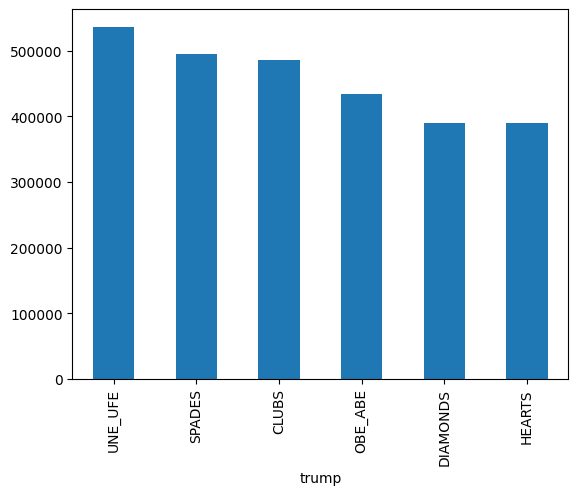

In [12]:
data['trump'].value_counts().plot(kind='bar')

#### Compare valid_cards & selected_card

Assert that the selected_card is part of the valid_cards. For simplicity we only check the first 5 rows

In [13]:
for selected_card, valid_cards in zip(data[selected_card_columns].head().values, data[valid_cards_columns].head().values):
    selected_card_str = convert_one_hot_encoded_cards_to_str_encoded_list(selected_card)
    valid_cards_str = convert_one_hot_encoded_cards_to_str_encoded_list(valid_cards)
    print(f'Selected Card: {selected_card_str}')
    print(f'Valid Cards: {valid_cards_str}')
    print(f'The selected card exists in valid cards: {selected_card_str[0] in valid_cards_str}\n')

Selected Card: [np.str_('H9')]
Valid Cards: [np.str_('H9')]
The selected card exists in valid cards: True

Selected Card: [np.str_('CJ')]
Valid Cards: [np.str_('DA'), np.str_('DK'), np.str_('D6'), np.str_('S9'), np.str_('CK'), np.str_('CJ'), np.str_('C8'), np.str_('C6')]
The selected card exists in valid cards: True

Selected Card: [np.str_('S9')]
Valid Cards: [np.str_('S9')]
The selected card exists in valid cards: True

Selected Card: [np.str_('C6')]
Valid Cards: [np.str_('DA'), np.str_('DK'), np.str_('D6'), np.str_('CK'), np.str_('C8'), np.str_('C6')]
The selected card exists in valid cards: True

Selected Card: [np.str_('C8')]
Valid Cards: [np.str_('DA'), np.str_('DK'), np.str_('D6'), np.str_('CK'), np.str_('C8')]
The selected card exists in valid cards: True



#### Make Sure the amount of played cards is less than 36

In [14]:
data[played_cards_columns].sum(axis=1).max()

np.int64(35)

### One-Hot-Encode Trump

In [ ]:
data.trump = data.trump.astype('category')

# THIS IS IMPORTANT TO MAKE SURE THE MODEL IS TRAINED WITH THE CORRECT INPUT ORDER -> ALSO LATER FOR PREDICITON USAGE
trump_columns = [
    'trump_DIAMONDS', 'trump_HEARTS', 'trump_SPADES', 'trump_CLUBS', 'trump_OBE_ABE', 'trump_UNE_UFE'
]

# One-hot encode the 'trump' column
trump_encoded = pd.get_dummies(data['trump'], prefix='trump')

# Concatenate the encoded column back to the original DataFrame
data = pd.concat([data, trump_encoded], axis=1)

data[trump_columns].head()

,trump_DIAMONDS,trump_HEARTS,trump_SPADES,trump_CLUBS,trump_OBE_ABE,trump_UNE_UFE
0,False,True,False,False,False,False
1,False,True,False,False,False,False
2,False,True,False,False,False,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


In [16]:
data.drop('trump', axis=1, inplace=True)

In [17]:
data.columns

Index(['played_cards_DA', 'played_cards_DK', 'played_cards_DQ',
       'played_cards_DJ', 'played_cards_D10', 'played_cards_D9',
       'played_cards_D8', 'played_cards_D7', 'played_cards_D6',
       'played_cards_HA',
       ...
       'selected_card_C9', 'selected_card_C8', 'selected_card_C7',
       'selected_card_C6', 'trump_CLUBS', 'trump_DIAMONDS', 'trump_HEARTS',
       'trump_OBE_ABE', 'trump_SPADES', 'trump_UNE_UFE'],
      dtype='object', length=114)

# Card Play Prediction Model (DNN)

In [18]:
data = data.astype(np.float32)

In [19]:
data.iloc[1].to_list()

[0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0]

In [20]:
feature_columns = played_cards_columns + valid_cards_columns + trump_columns

In [21]:
# Split into features (X) and target (y)
X = np.asarray(data[ feature_columns ])
y = np.asarray(data[
    selected_card_columns
])

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Define Model

In [33]:
model = Sequential()

model.add(Dense(228, activation="relu", input_dim=X_train.shape[1]))
model.add(Dense(114, activation="relu"))
model.add(Dense(72, activation="relu"))
model.add(Dense(y_train.shape[1], activation="softmax"))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.5619 - loss: 1.0943 - val_accuracy: 0.6037 - val_loss: 0.9333
Epoch 2/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accuracy: 0.6164 - loss: 0.8963 - val_accuracy: 0.6263 - val_loss: 0.8675
Epoch 3/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 26s 940us/step - accuracy: 0.6309 - loss: 0.8548 - val_accuracy: 0.6377 - val_loss: 0.8411
Epoch 4/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 27s 988us/step - accuracy: 0.6437 - loss: 0.8276 - val_accuracy: 0.6461 - val_loss: 0.8199
Epoch 5/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 27s 996us/step - accuracy: 0.6539 - loss: 0.8052 - val_accuracy: 0.6564 - val_loss: 0.8032
Epoch 6/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.6614 - loss: 0.7910 - val_accuracy: 0.6636 - val_loss: 0.7958
Epoch 7/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - accuracy: 0.6679 - loss: 0.7792 - val_accuracy: 0.6672 - val_loss: 0.7841
Epoch 8/20
27346/27346 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - accu

In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

17091/17091 ━━━━━━━━━━━━━━━━━━━━ 7s 396us/step - accuracy: 0.6875 - loss: 0.7417
Test Loss: 0.7412577271461487, Test Accuracy: 0.6881265640258789


In [ ]:
single_sample = X_test[0]

single_sample = single_sample.reshape(1, -1)

prediction = model.predict(single_sample)

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[2.0293723e-04 4.1825956e-04 1.6247183e-02 1.1123820e-01 8.8868633e-02
  1.0779480e-10 5.3600030e-07 6.4465627e-11 4.4431788e-11 7.1975110e-06
  1.1750286e-02 2.6129436e-02 5.8103327e-02 3.7032005e-03 6.9214018e-08
  1.4600512e-01 3.8209129e-03 6.1679580e-06 3.6725129e-03 1.8448540e-03
  3.2614019e-02 5.8471218e-02 1.6587367e-06 2.1577601e-03 1.0035120e-01
  3.2855663e-01 6.0677968e-07 2.8060342e-03 1.1217345e-08 5.8072551e-06
  3.0026764e-03 3.1004740e-06 7.9636093e-09 9.7002658e-06 1.3273201e-07
  5.2192621e-07]]


In [46]:
convert_int_encoded_cards_to_str_encoded([np.argmax(prediction)])

[np.str_('S7')]

In [36]:
model.save('card_prediction_v02.keras')